###PySpark.ml with Pipeline for Logistic Regression based Documents Classification

This pyspark.ml notebook targets Databricks Community!  

This machine learning solution demonstrates predictive analysis (logistic regression based document classification) of food inspection reports from Chicago Data Portal open dataset.
  
Source dataset: Chicago data portal, food inspection data (Food_Inspections1.csv is training dataset & Food_Inspections2.csv is hold-out validation dataset taken from Azure HDInsight)  
Uploaded it into Databricks dbfs://FileStore/tables/

####Spark Pipeline concept  

Refer to Spark's pipeline.scala source code at https://github.com/apache/spark/blob/master/mllib/src/main/scala/org/apache/spark/ml/Pipeline.scala  

Pipeline consists of 1+ stages and each stage can be either Estimator or Transformer or combo of both. Pipeline.fit(...) processes each stage by invoking Estimator.fit(...) to produce corresponding Transformer and then invokes resulting Transformer.transform(...) as per stage type to produce output which is used as input in the subsequent stage.

In [3]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, NGram
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [4]:
%fs ls /FileStore/tables/

path,name,size
dbfs:/FileStore/tables/Food_Inspections1.csv,Food_Inspections1.csv,19085447
dbfs:/FileStore/tables/Food_Inspections2.csv,Food_Inspections2.csv,14330038


In [5]:
def readDataset(fp) :
  df = spark.read.csv(fp, 
                           header=True, 
                           multiLine=True, 
                           ignoreLeadingWhiteSpace=True, 
                           ignoreTrailingWhiteSpace=True, 
                           encoding="UTF-8",
                           sep=',',
                           quote='"', 
                           escape='"',
                           maxColumns=17,
                           inferSchema=True)

  # We are concerned about just 'Violations' & 'Results'
  # NOTE that 'Food_Inspections2.csv' is validation dataset and hence it has 'results' label column too
  df = df.select(col("Results"), col("Violations"))
  #df = df.na.fill({'violations': ''})
  return df

In [6]:
train_df = readDataset("/FileStore/tables/Food_Inspections1.csv")

In [7]:
# NOTE that 'Results' has 5 types for the food inspection classification
# But cleaning rows with NA reveals that 'Business Not Located' & 'Out of Business' labeled rows are the ones with NA
train_df.select('Results').distinct().show()

+--------------------+
 Results|
+--------------------+
 Fail|
Business Not Located|
 Pass w/ Conditions|
 Out of Business|
 Pass|
+--------------------+

In [8]:
nTrainRecords = train_df.count()

train_df = train_df.dropna()
nTrainRecordsPruned = train_df.count()

print("Training dataset records count: " + str(nTrainRecordsPruned) + "; after pruning {" + str(nTrainRecords - nTrainRecordsPruned) + "} records with NA")

Training dataset records count: 10469; after pruning {2632} records with NA

In [9]:
# Retaining pass/fail and filtering out remaining inspections to focus on binary classification
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
udfLabelResult = udf(labelForResults, DoubleType())

labeledTrainingData = train_df.select(udfLabelResult(train_df.Results).alias('label'), train_df.Violations).where('label >= 0')
labeledTrainingData.show(5)

+-----+--------------------+
label| Violations|
+-----+--------------------+
 0.0|24. DISH WASHING ...|
 0.0|2. FACILITIES TO ...|
 1.0|33. FOOD AND NON-...|
 1.0|32. FOOD AND NON-...|
 1.0|19. OUTSIDE GARBA...|
+-----+--------------------+
only showing top 5 rows

##### Setup Spark.ml Pipeline

In [11]:
# Spark.ml pipeline expects 'features' columns-set for the independent variables set & 'label' column
# 'features' in this present use case is the documents tokens frequency columns altogether
# Understand that sheer frequency of tokens are the only input to this predictive analytics
tokenizer = Tokenizer(inputCol="Violations", outputCol="words")
wordsRemover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="stop_words_pruned")
hashingTF = HashingTF(inputCol=wordsRemover.getOutputCol(), outputCol="hashing_tf")

# minDocFreq is to ignore those tokens which appear in fewer than minDocFreq documents
tfidf = IDF(minDocFreq=5, inputCol=hashingTF.getOutputCol(), outputCol="features")

# 2-gram is useful when a word alone does not mean much than when used along with its complementary
# Using 1&2-gram might give stronger/better result than just 1-gram (TODO: need to fix injecting ngram into piepeline)
#ngram2 = NGram(n=2, inputCol=tfidf.getOutputCol(), outputCol="features")

# regParam is regularization lambda... even ElasticNet regularization can be used through elasticNetParam
lr = LogisticRegression(maxIter=10, regParam=0.01)

# tokenizer, wordsRemover & hashingTF are of type Tranasformer
# tfidf stage involves both Estimator & Transform (it used in standalone mode then it should be used as per below
#               idf = IDF().fit(tf)
#               tfidf = idf.transform(tf))
# lr stage involves only Estimator
pipeline = Pipeline(stages=[tokenizer, wordsRemover, hashingTF, tfidf, lr])
model = pipeline.fit(labeledTrainingData)

In [12]:
# Model looks for just 'violations' column for predicting
# Note that same pipeline of Tokenizer & HashingTF is implicitly applied on the test data which is then used for prediction
# Spark.ml transform() introduces 'prediction' column
validation_df = readDataset("/FileStore/tables/Food_Inspections2.csv")

#validation_df = validation_df.na.fill({'Violations': ''})
validation_df = validation_df.dropna()

In [13]:
# NOTE that even this testing dataset has 1866 NA/empty rows out of 10k records, but they cannot be dropped

#nTestRecords = validation_df.count()
#nTestRecordsPruned = validation_df.dropna().count()
#print("Testing dataset records count: " + str(nTestRecordsPruned) + "; after pruning {" + str(nTestRecords - nTestRecordsPruned) + "} records with NA")

In [14]:
# Observe that this prediction_df dataframe contains output of all stages of our pipeline and additionally 'prediction' & 'rawPrediction'
predictions_df = model.transform(validation_df)

In [15]:
display(predictions_df.select("Results", "stop_words_pruned"))

Results stop_words_pruned Fail List(37., toilet, room, doors, self, closing:, dressing, rooms, lockers, provided:, complete, separation, living/sleeping, quarters, -, comments:, instructed, fix, broken, self, closing, device, washroom, door., |, 40., refrigeration, metal, stem, thermometers, provided, conspicuous, -, comments:, food, establishments, display,, prepare,, store, potentially, hazardous, foods, shall, calibrated, metal, stem, thermometers,, provided, conspicuous,, refrigerated, hot, food, units., , instructed, provide, thermometter, visible, inside, coolers., |, 36., lighting:, required, minimum, foot-candles, light, provided,, fixtures, shielded, -, comments:, shielding, protect, broken, glass, falling, food, shall, provided, artificial, lighting, sources, preparation,, service,, display, facilities., , lightbulbs, must, shielded, inside, hot, holding, display, unit, provide, shatterfroofed, lightbulb., , , |, 18., evidence, rodent, insect, outer, openings, protected/rodent, proofed,, written, log, shall, maintained, available, inspectors, -, comments:, necessary, control, measures, shall, used, effectively, minimize, eliminate, presence, rodents,, roaches,, vermin, insects, premises, food, establishments,, food-transporting, vehicles,, vending, machines., , found, front, entrance, door, rodent, proofed., noted, 1/2, inch, gap/opening, bottom, door., instructed, rodent-proofed, bottom, said, door., serious, citation, issued, 7-38-020, |, 41., premises, maintained, free, litter,, unnecessary, articles,, cleaning, , equipment, properly, stored, -, comments:, parts, food, establishment, parts, property, used, connection, operation, establishment, shall, kept, neat, clean, produce, offensive, odors., , instructed, clean, maintain, rear, outside, area.) Pass w/ Conditions List(9., water, source:, safe,, hot, &, cold, city, pressure, -, comments:, food, establishments, shall, provided, adequate, supply, hot, cold, water, pressure, properly, connected, city, water, supply, , sinks, checked, upon, inspection, highest, temperature, 89, f., , , 110, f, minimum, required, ware, washing., , plumbers, arrived, inspection., , 115, f, hot, water, restored, time, inspection., |, 10., sewage, waste, water, disposal,, back, siphonage,, cross, , connection, and/or, back, flow, -, comments:, food, establishments,, shall, adequate, sewage, waste, water, disposal, facilities, comply, requirements, plumbing, section, municipal, code, chicago., , floor, drain, kitchen, backing, waste, water, kitchen, floor., , plumbers, arrived, inspection, rodded, drain, flowed, properly., |, 38., ventilation:, rooms, equipment, vented, required:, plumbing:, installed, maintained, -, comments:, rear, dish, scrapeing, sink, three, compartment, sink, cracks, gaps, leak, water, onto, floor,, repair, sinks, longer, leak., |, 34., floors:, constructed, per, code,, cleaned,, good, repair,, coving, installed,, dust-less, cleaning, methods, used, -, comments:, floors, shall, constructed, per, code,, smooth, easily, cleaned,, kept, clean, good, repair., , floor, baseboard, behind, grease, trap, filthy, water, damaged,, sanitize, repair, said, area., |, 33., food, non-food, contact, equipment, utensils, clean,, free, abrasive, detergents, -, comments:, food, non-food, contact, surfaces, equipment, food, storage, utensils, shall, thoroughly, cleaned, sanitized, daily., , opener, metal, fileings, worn, parts,, clean, repair, opener, reduce, amount, possible, metal, adulteration., , ice, machine, interior, lip, dirty,, wash,, rinse, sanitize, food, dispensing, utensils, equipment, clean,, sanitary, maintained, daily, basis., |, 36., lighting:, required, minimum, foot-candles, light, provided,, fixtures, shielded, -, comments:, rooms, food, drink, prepared,, utensils, washed,, shall, lighted, minimum, 50-foot, candles, light, available, work, surfaces., , replace, broken, light, shields, rear, kitchen.) Pass List(29., previous, minor, violation(s), corrected, 7-42-09

In [16]:
# BinaryClassificationEvaluator expects rawPrediction
predictions_df = predictions_df.select(udfLabelResult(predictions_df.Results).alias('label'), predictions_df.Violations, predictions_df.prediction, predictions_df.rawPrediction).where('label >= 0')
predictions_df.show(5)

+-----+--------------------+----------+--------------------+
label| Violations|prediction| rawPrediction|
+-----+--------------------+----------+--------------------+
 0.0|37. TOILET ROOM D...| 0.0|[5.39643272272093...|
 1.0|9. WATER SOURCE: ...| 1.0|[-4.4859906378367...|
 1.0|29. PREVIOUS MINO...| 1.0|[-5.9788673912389...|
 1.0|2. FACILITIES TO ...| 1.0|[-1.8308810070117...|
 1.0|31. CLEAN MULTI-U...| 1.0|[-5.4685572341087...|
+-----+--------------------+----------+--------------------+
only showing top 5 rows

In [17]:
evaluator = BinaryClassificationEvaluator(metricName = "areaUnderROC")
evaluator.evaluate(predictions_df)

Out[ 17 ]: 0.9189519670067249

In [18]:
# Confusion matrix (actually most of the true-negative & false-positive are corresponding to NA/empty records in testing dataset)
tp = predictions_df[(predictions_df.label == 1) & (predictions_df.prediction == 1)].count()
tn = predictions_df[(predictions_df.label == 0) & (predictions_df.prediction == 0)].count()
fp = predictions_df[(predictions_df.label == 0) & (predictions_df.prediction == 1)].count()
fn = predictions_df[(predictions_df.label == 1) & (predictions_df.prediction == 0)].count()
(tp, tn, fp, fn)

Out[ 18 ]: (5972, 1381, 496, 284)

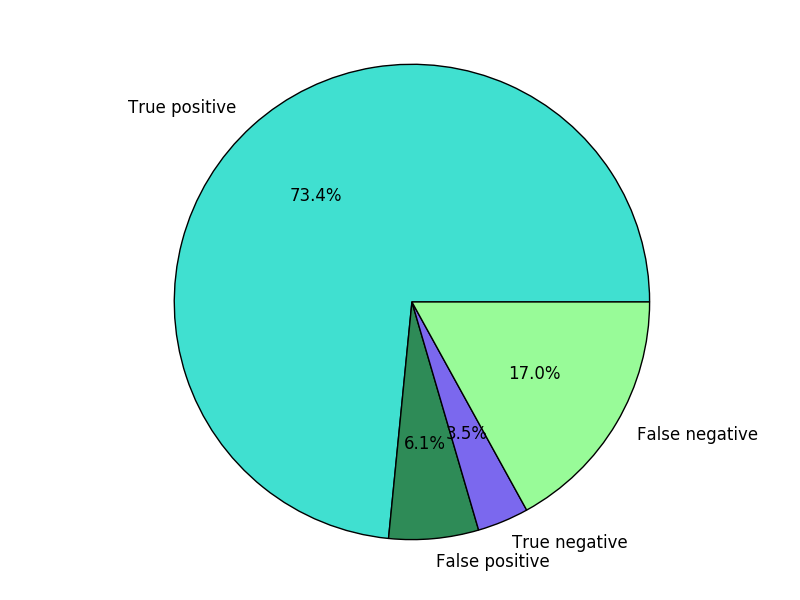

In [19]:
#%matplotlib inline
import matplotlib.pyplot as plt

labels = ['True positive', 'False positive', 'True negative', 'False negative']
sizes = [tp, fp, fn, tn]
colors = ['turquoise', 'seagreen', 'mediumslateblue', 'palegreen', 'coral']
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
ax.axis('equal')
display(fig)

#### Appendix  

Further activity which can be tried with this notebook kernel: -
1. Inject ngram into spark.ml pipeline to accomodate 2-gram too
2. Integrate hold-out or cross validation strategy into pipeline
3. Hyperparameters grid search to obtain better model & its integration into pipeline
4. Drop Na/empty from both training & testing (ideally, testing data must not have empty Violations)